<a href="https://colab.research.google.com/github/willschlitzer/fastai_lessons/blob/main/digit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 719 kB 6.7 MB/s 
     |████████████████████████████████| 4.7 MB 64.9 MB/s 
     |████████████████████████████████| 1.3 MB 57.1 MB/s 
     |████████████████████████████████| 365 kB 55.3 MB/s 
     |████████████████████████████████| 212 kB 52.0 MB/s 
     |████████████████████████████████| 115 kB 59.3 MB/s 
     |████████████████████████████████| 101 kB 14.8 MB/s 
     |████████████████████████████████| 127 kB 65.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from fastbook import *
from fastai.vision.all import *

In [3]:
# Get MNIST samples
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid')]

In [5]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [6]:
# Create a list of the png files for 3 and 7
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
# Open an image in the "3" category
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

numpy array of the image




In [8]:
# Display a portion of the image as a numpy array
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# Create a dataframe from a tensor of the image
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Create tensor images of the average pixel values of all images

In [10]:
# Create a list of tensors for the 3 and 7 images
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)


(6131, 6265)

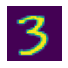

In [11]:
show_image(three_tensors[1])

In [12]:
# Stack all of the tensors to get an average value
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

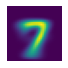

In [13]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

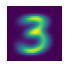

In [14]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [15]:
# Perform a loss function to determine if 3 is closer to the ideal 7 or 3
a_3 = stacked_threes[1]
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [16]:
# Import and stack the valid data
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [17]:
# Function to see how inputs are from one another
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [18]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1087, 0.1336, 0.1186,  ..., 0.1315, 0.1134, 0.1142]),
 torch.Size([1010]))

Test if a function is a 3

In [19]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [20]:
# Test on a single 3 image
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [21]:
# Perform 3 check on all valid 3s
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [22]:
# Check accuracy on valid 3
accuracy_3s = is_3(valid_3_tens).float().mean()
# Check accuraacy on valid 7
accuracy_7s = (1 - is_3(valid_7_tens).float().mean())
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

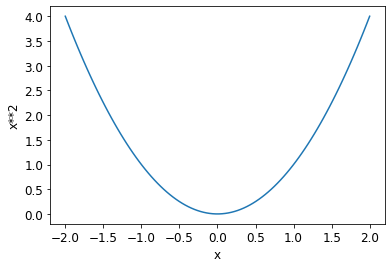

In [28]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

In [40]:
xt = tensor(3.).requires_grad_()

In [41]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [42]:
yt.backward()

In [44]:
xt.grad

tensor(6.)

In [52]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [53]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [54]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])